In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
x0 = -5  # "realistic" sample which the model needs to learn to generate
n_steps = 100  # number of denoising time steps

In [3]:
alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - sqrt_alphas_cumprod ** 2)

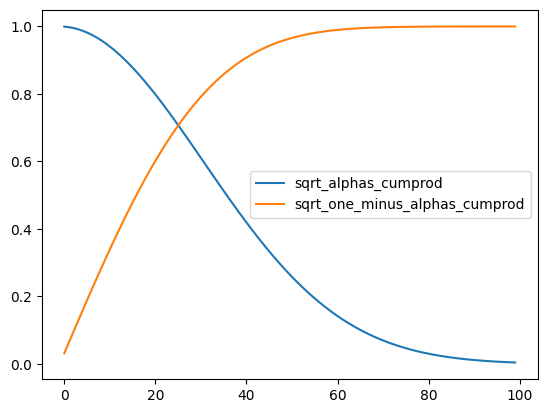

In [4]:
plt.plot(sqrt_alphas_cumprod, label="sqrt_alphas_cumprod")
plt.plot(sqrt_one_minus_alphas_cumprod, label="sqrt_one_minus_alphas_cumprod")
plt.legend()

In [5]:
def q_sample(x_0, t, noise):
    """
    Sample x at time t given the value of x at t=0 and the noise
    """
    return sqrt_alphas_cumprod.gather(-1, t) * x_0 + sqrt_one_minus_alphas_cumprod.gather(-1, t) * noise

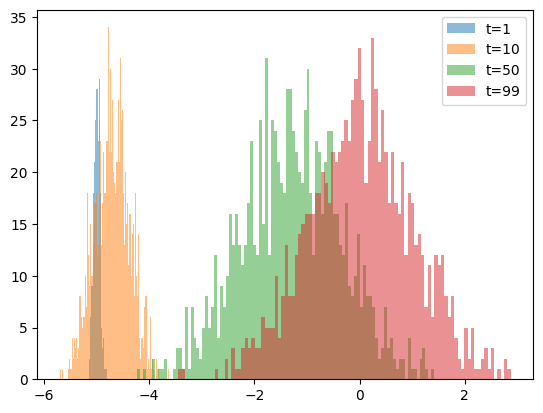

In [6]:
for t in [1, n_steps // 10, n_steps // 2, n_steps - 1]:
    noised_x = q_sample(x0, torch.tensor(t), torch.randn(1000))
    plt.hist(noised_x.numpy(), bins=100, alpha=0.5, label=f"t={t}");
plt.legend()

Text(0, 0.5, 'x')

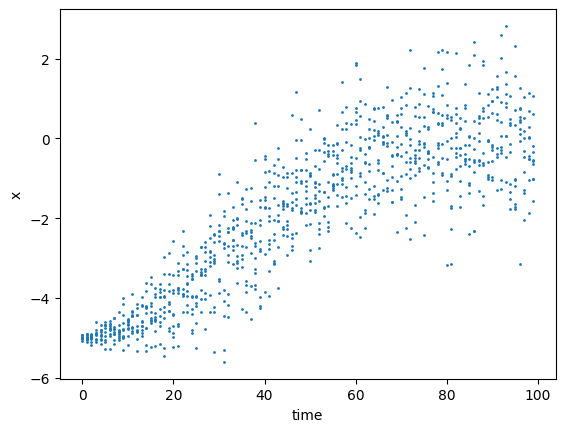

In [7]:
res = [(t, q_sample(x0, torch.tensor(t), torch.randn(1)).item()) for _ in range(10) for t in range(n_steps)]
x, y = list(zip(*res))
plt.scatter(x, y, s=1)
plt.xlabel("time")
plt.ylabel("x")

In [8]:
class DenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(1.))
        self.b = torch.nn.Parameter(torch.tensor(0.))
        self.c = torch.nn.Parameter(torch.tensor(0.))

    def forward(self, x, t):
        return self.a * x + self.b * t + self.c

In [9]:
def p_loss(x, t):
    # Generate a noise
    noise = torch.randn(t.shape)
    # Compute x at time t with this value of the noise - forward process
    noisy_x = q_sample(x, t, noise)
    # Use our trained model to predict the value of the noise, given x(t) and t
    noise_computed = denoise(noisy_x, t)
    # Compare predicted value of the noise with the actual value
    return F.mse_loss(noise, noise_computed)

In [10]:
denoise = DenoiseModel()
optimizer = torch.optim.Adam(denoise.parameters())

n_epochs = 10000
batch_size = 1000
for step in range(n_epochs):
    optimizer.zero_grad()
    t = torch.randint(0, n_steps, (batch_size, ))  # Pick random time step
    loss = p_loss(x0, t)
    loss.backward()
    if step % (n_epochs // 10) == 0:
        print(f"loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")
    optimizer.step()
print(f"final: loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")

loss=6.5469; a=1.0000, b=0.0000, c=0.0000
loss=0.8491; a=0.3550, b=-0.0055, c=0.6876
loss=0.7198; a=0.2850, b=-0.0110, c=0.9907
loss=0.6043; a=0.3457, b=-0.0153, c=1.3262
loss=0.5002; a=0.4280, b=-0.0211, c=1.7814
loss=0.4464; a=0.5276, b=-0.0277, c=2.3178
loss=0.3358; a=0.6287, b=-0.0351, c=2.8752
loss=0.3074; a=0.7193, b=-0.0407, c=3.3837
loss=0.2846; a=0.7917, b=-0.0457, c=3.7769
loss=0.2968; a=0.8350, b=-0.0488, c=4.0230
final: loss=0.2896; a=0.8581, b=-0.0503, c=4.1358


In [11]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def p_sample(x, t):
    """
    One step of revese process sampling - Algorithm 2 from the paper
    """
    alpha_t = alphas.gather(-1, t)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t)
    # Get mean x[t - 1] conditioned at x[t] - see eq. (11) in the paper
    model_mean = torch.sqrt(1.0 / alpha_t) * (x - (1 - alpha_t) * denoise(x, t) / sqrt_one_minus_alphas_cumprod_t)
    # Get variance of x[t - 1]
    model_var = posterior_variance.gather(-1, t)
    # Samples for the normal distribution with given mean and variance
    return model_mean + torch.sqrt(model_var) * torch.randn(1)

Text(0.5, 1.0, 'Reverse process - denoising')

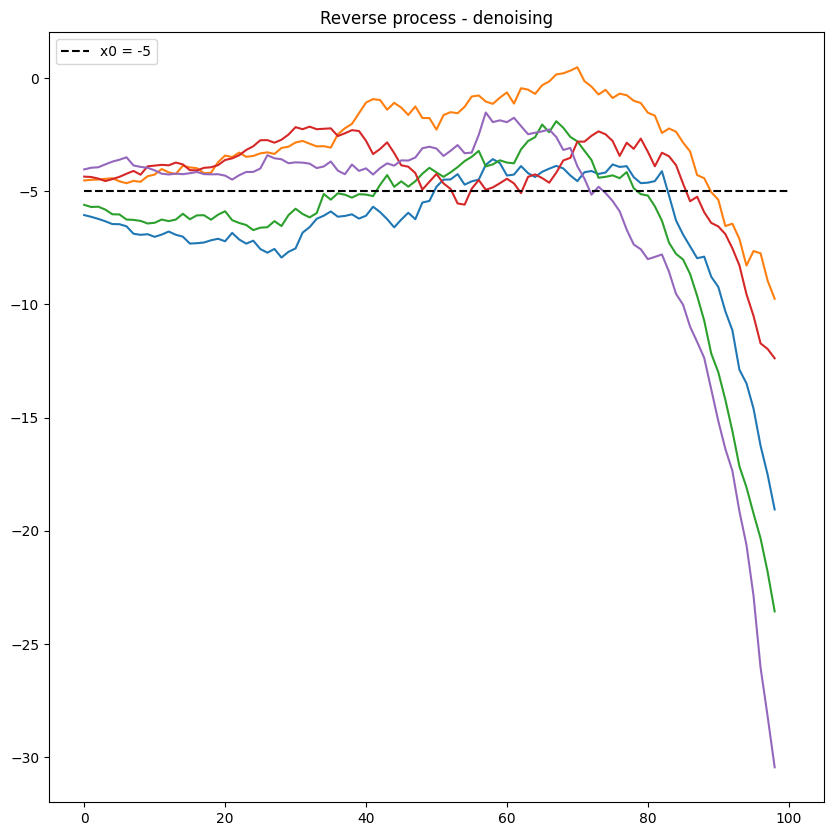

In [12]:
plt.figure(figsize=(10, 10))
for _ in range(5):
    x_gens = []
    x_gen = torch.randint(-50, 50, (1,))
    for i in range(n_steps - 1, 0, -1):
        x_gen = p_sample(x_gen, torch.tensor(i))
        x_gens.append(x_gen.detach().numpy()[0])
    plt.plot(x_gens[::-1])
plt.hlines(x0, 0, 100, color="black", linestyle="--", label=f"x0 = {x0}")
plt.legend(loc="upper left")
plt.title("Reverse process - denoising")

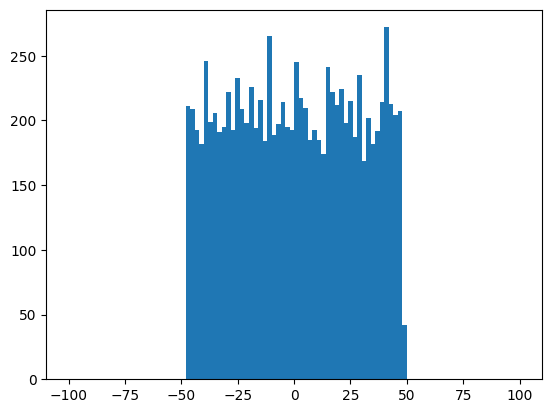

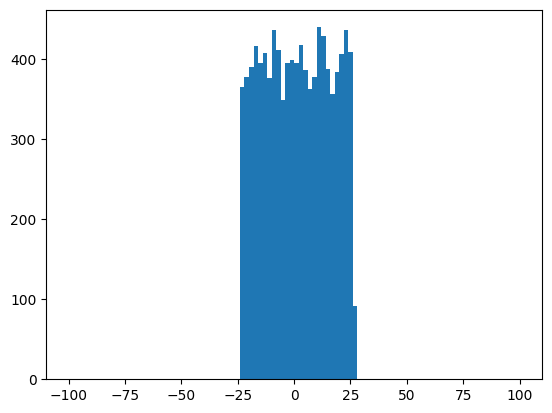

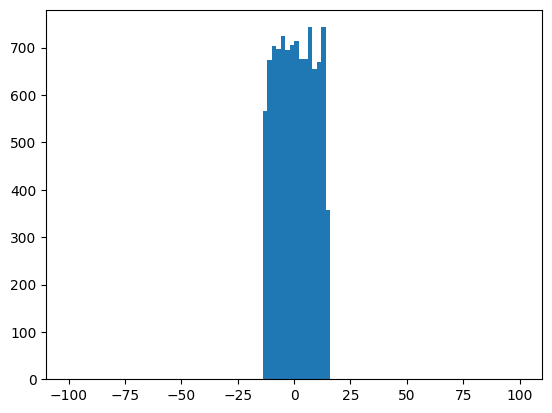

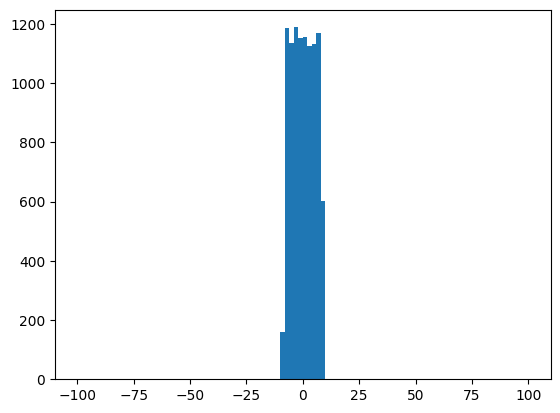

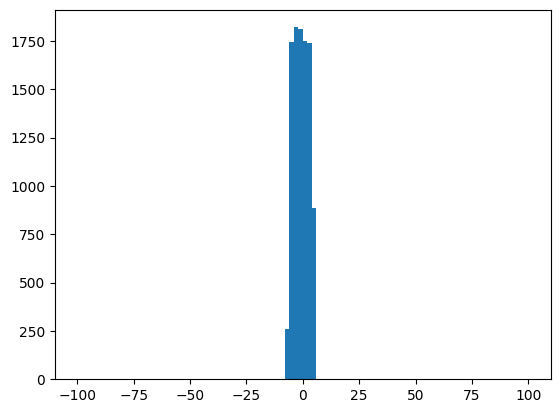

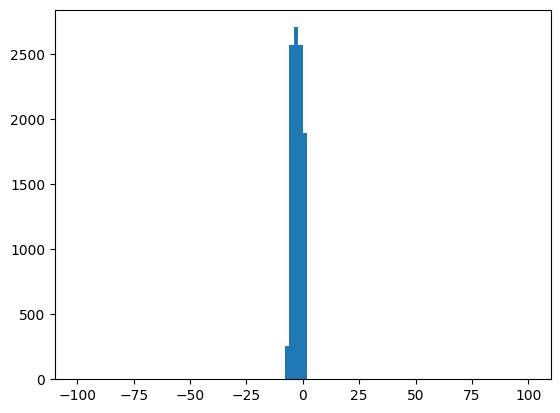

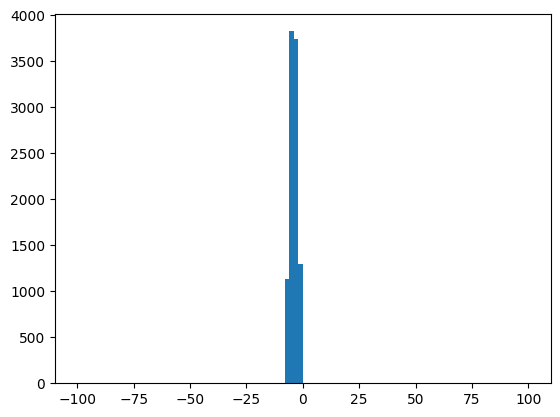

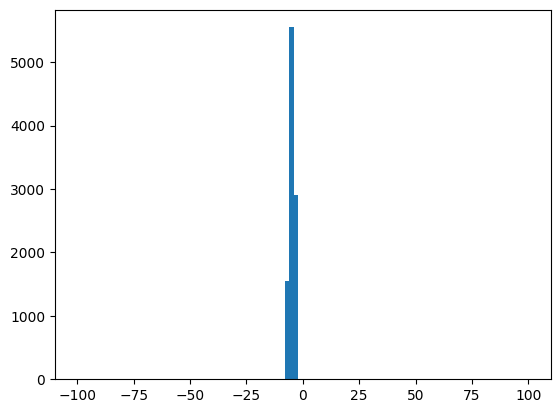

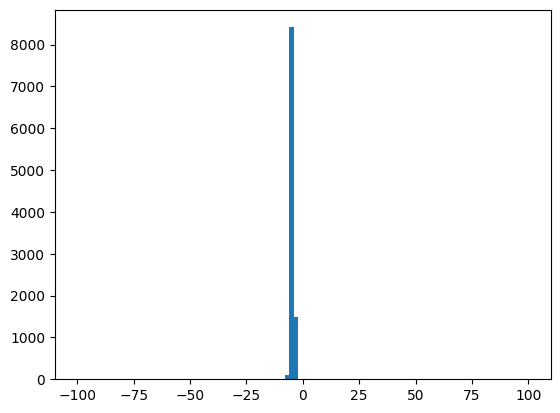

In [13]:
# Create a sample of 10000 "noisy" datapoint at time t = 100
x_gen = torch.randint(-100, 100, (10000,))
for i in range(n_steps - 1, 0, -1):
    # denoise the sample step by step backawards in time
    x_gen = p_sample(x_gen, torch.tensor(i))
    if i % 10 == 0:
        plt.hist(x_gen.detach().numpy(), range=(-100, 100), bins=100)
        plt.show()

In [14]:
from collections import defaultdict

x_scale = 4 # Range of x to plot
all_res = []
for t0 in range(n_steps): # Go over all time steps and over x in a certain range
    res = defaultdict(list)
    for x in np.linspace(-x_scale, x_scale, 10):
        noise_size = 1000
        # Generate noise and apply it to x to get "noisy" x
        noise = torch.randn((noise_size, 1))
        t = torch.tensor((t0,))
        noisy_x = q_sample(x0, t, noise)
        bin_size = 0.01
        # Group data by "noisy" x and compute average value of noise for a given "noisy" x
        noisy_quantised = ((noisy_x[:, 0] / bin_size).round() * bin_size).numpy()
        for i in range(noise_size):
            res[noisy_quantised[i]].append(noise[i, 0].item())
    averaged = {k: np.mean(res[k]) for k in res}
    x_noisy = list(averaged.keys())
    for k in averaged:
        all_res.append([t0, k, averaged[k]])

In [15]:
def get_noise(x_noisy, x0, t):
    return (x_noisy - x0 * sqrt_alphas_cumprod[t]) / sqrt_one_minus_alphas_cumprod[t]

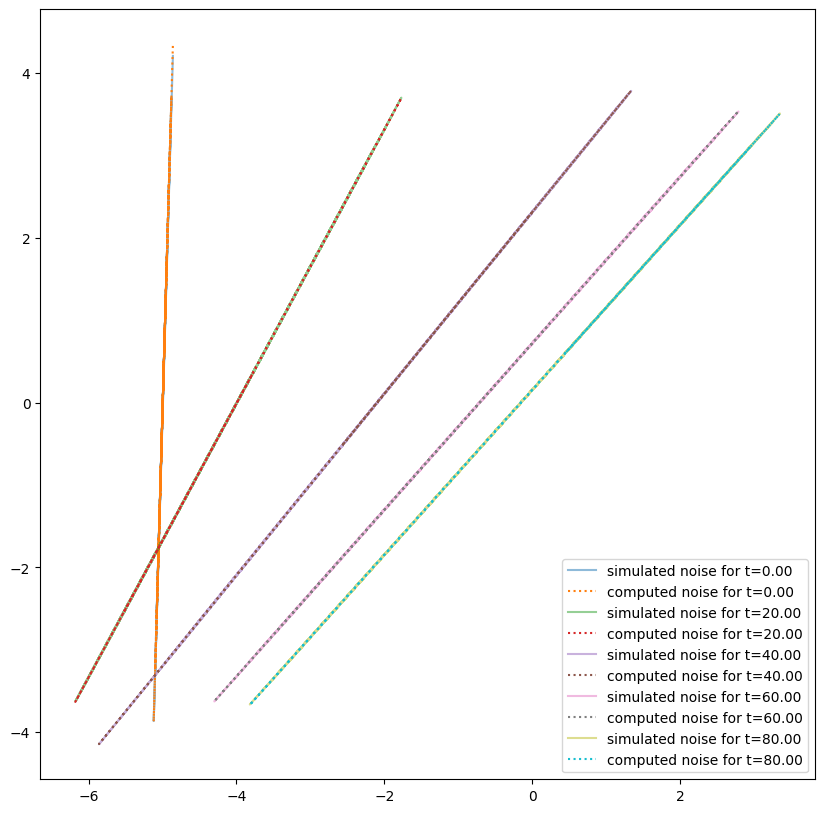

In [16]:
plt.figure(figsize=(10, 10))
for t in range(0, n_steps, n_steps // 5):
    all_fixed_t = [val for val in all_res if val[0] == t]
    x_axis = [val[1] for val in all_fixed_t]
    plt.plot(x_axis, [val[2] for val in all_fixed_t], label=f"simulated noise for t={t:.2f}", linestyle="-", alpha=0.5)
    computed_noise = [get_noise(val[1], x0, t)  for val in all_fixed_t]
    plt.plot(x_axis, computed_noise, label=f"computed noise for t={t:.2f}", linestyle=":")
plt.legend(loc="lower right")

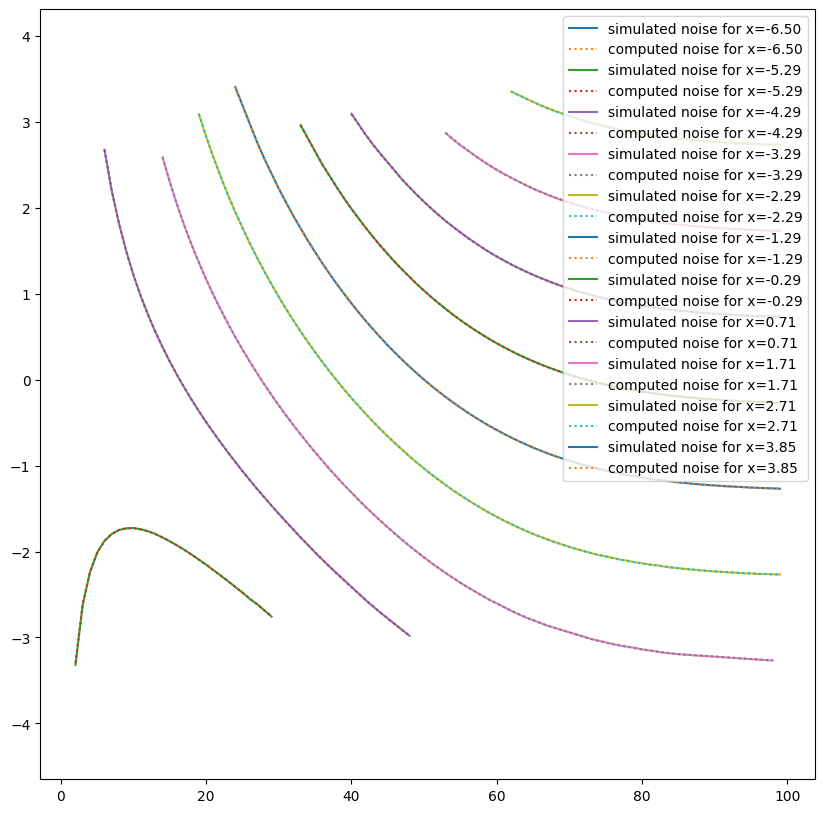

In [17]:
possible_noisy_x = sorted(set([val[1] for val in all_res]))
plt.figure(figsize=(10, 10))
for x_fixed in possible_noisy_x[::n_steps]:
    all_fixed_x = [x for x in all_res if np.abs(x[1] - x_fixed) < 1e-8]
    x_axis = [val[0] for val in all_fixed_x]
    plt.plot(x_axis, [val[2] for val in all_fixed_x], label=f"simulated noise for x={x_fixed:.2f}", linestyle="-")
    computed_noise = [get_noise(x_fixed, x0, val[0])  for val in all_fixed_x]
    plt.plot(x_axis, computed_noise, label=f"computed noise for x={x_fixed:.2f}", linestyle=":")
plt.legend(loc="upper right")